# Herron Topic 2 - Practice

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf

In [2]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
# %config InlineBackend.figure_format = 'retina'

## Announcements

1. I am still grading your projects; I hope to finish them by next Tuesday
2. I posted 50 practice problems to prepare for the end-of-course Programming Assessment here: <https://northeastern.instructure.com/courses/207607/discussion_topics/2727917>
    1. I built 5 autograded notebooks to help you prepare for the assessment, and I will build more in the coming weeks
    2. To run these notebooks, install the `otter-grader` package: In the Anaconda command prompt (or Terminal on Mac) run `conda activate fina6333` then `conda install otter-grader`
    3. See the video at the link above for details

## Five-Minute Review


1. Technical analysis (TA) is a method of evaluating trends in trading prices and volume (and open interest  in the futures and options markets only)
2. The three tenants of TA are:
    1. Markets discount everything
    2. Prices move in trends
    3. History repeats itself, so these trends are recurring
3. Academics have not found much evidence that TA generate profits that exceed transaction costs, but we will spend a week on it for three reasons:
    1. You asked for it, and it will help build our data analytics skills
    2. It is a small part of the Chartered Financial Analyst (CFA) curriculum
    3. That TA still receives attention 60 years after the Efficient Markets Hypothesis (EMH) suggests that it has some value that academics have been unable to measure

##  Practice

### Implement the SMA(20) strategy with Bitcoin from the lecture notebook

Try to create the `btc_sma` data frame from the `btc` data frame in one code cell with one assignment (i.e., one `=`).

In [3]:
btc = (
    yf.download(
        tickers='BTC-USD',
        auto_adjust=False,
        progress=False,
        multi_level_index=False
    )
    .iloc[:-1] # drop incomplete trading day
)


After class, I converted our code to a function.
We might want to test different moving average parameters, and a function makes these tests easier.

The following `calc_sma()` function accepts:

1. A data frame `df` of daily values from `yfinance.download()`
2. An integer `window` that specifies the number of trading days in the SMA window

And returns the original data frame `df` plus the following columns:

1. `Return` with daily returns
2. `SMA` for the `window`-trading-day moving average
3. `Position` for the weight on the security each day
4. `Strategy` for the return on the strategy each day

In [4]:
def calc_sma(df, window=20):
    return (
        df
        .assign(
            Return=lambda x: x['Adj Close'].pct_change(),
            SMA=lambda x: x['Adj Close'].rolling(window=window).mean(),
            Position=lambda x: np.select(
                condlist=[
                    x['Adj Close'].shift(1) > x['SMA'].shift(1),
                    x['Adj Close'].shift(1) <= x['SMA'].shift(1)
                ],
                choicelist=[1, 0],
                default=np.nan
            ),
            Strategy=lambda x: x['Position'] * x['Return']
        )
    )

In [5]:
btc_sma = btc.pipe(calc_sma, window=20)

It can be helpful to visualize a few places where the price (here `Adj Close`) crosses the moving average (here SMA(20)).
In class, we found that there are a few changes in position in the middle of October, 2014.
The following code create two subplots in one figure, then puts one plot in each of the subplots.

For the first crossover on October 12, we *buy* at the close on October 12 and earn the security return on October 13.
For the second crossover on October 23, we *sell* at the close on October 23 and earn zero return on October 24.

In [6]:
COLUMNS = {
    'Adj Close': 'Price',
    'SMA': 'SMA(20)',
    'Return': 'Buy-And-Hold',
    'SMA': 'SMA(20)'
    
}

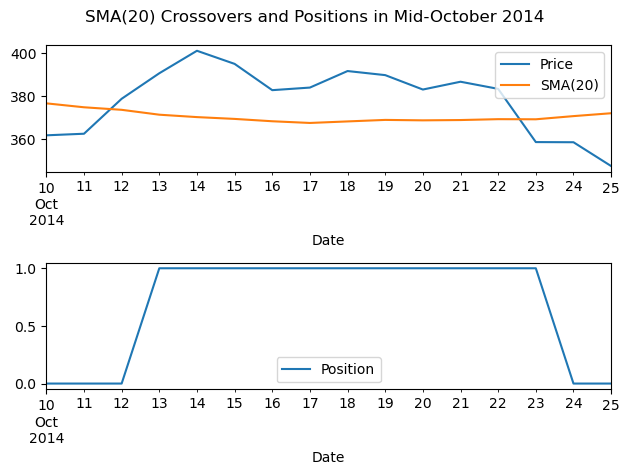

In [7]:
fig, ax = plt.subplots(2, 1)
df = btc_sma.loc['2014-10-10':'2014-10-25']
df[['Adj Close', 'SMA']].rename(columns=COLUMNS).plot(ax=ax[0])
df[['Position']].plot(ax=ax[1])
plt.suptitle('SMA(20) Crossovers and Positions in Mid-October 2014')
plt.tight_layout()
plt.show()

We can compare the total returns on BTC and our SMA(20) strategy!
We `.dropna()` first because the SMA(20) strategy needs 20 days of data to make its first investing decision.

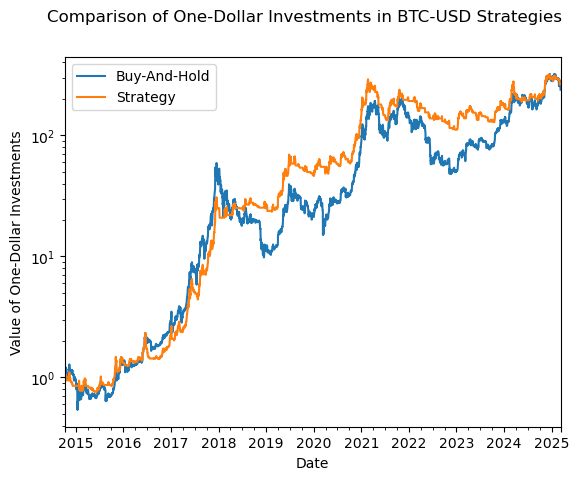

In [8]:
(
    btc_sma
    [['Return', 'Strategy']]
    .dropna()
    .rename(columns=COLUMNS)
    .add(1)
    .cumprod()
    .plot()
)
plt.semilogy()
plt.suptitle('Comparison of One-Dollar Investments in BTC-USD Strategies')
plt.ylabel('Value of One-Dollar Investments')
plt.show()

These total returns, at least today, are similar!

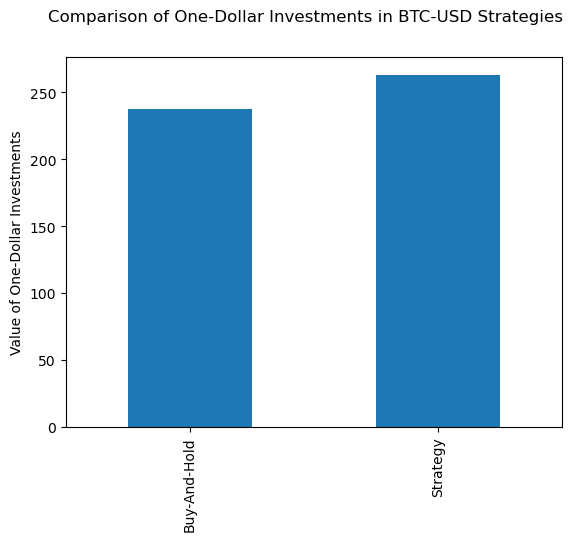

In [9]:
(
    btc_sma
    [['Return', 'Strategy']]
    .dropna()
    .rename(columns=COLUMNS)
    .add(1)
    .prod()
    .plot(kind='bar')
)
plt.suptitle('Comparison of One-Dollar Investments in BTC-USD Strategies')
plt.ylabel('Value of One-Dollar Investments')
plt.show()

However, the Sharpe ratio of the SMA(20) is higher, because time out of the market when `Position=0` reduces risk.
For simplicity, we will ignore the risk-free rate in the Sharpe ratio formula.

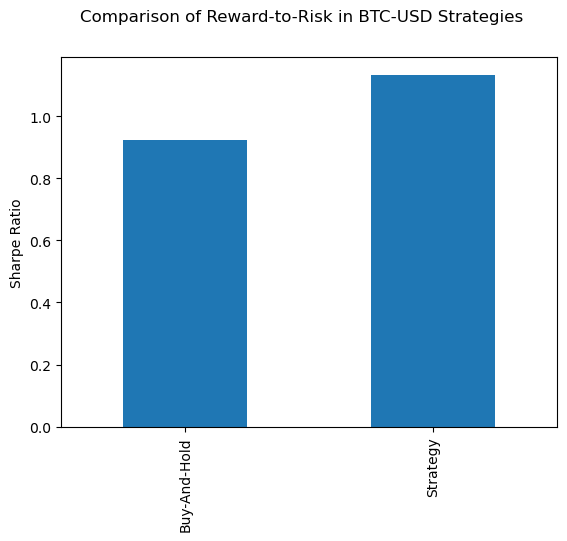

In [10]:
(
    btc_sma
    [['Return', 'Strategy']]
    .dropna()
    .rename(columns=COLUMNS)
    .apply(lambda x: np.sqrt(252) * x.mean() / x.std())
    .plot(kind='bar')
)
plt.suptitle('Comparison of Reward-to-Risk in BTC-USD Strategies')
plt.ylabel('Sharpe Ratio')
plt.show()

But how persistent is this outperformance in terms of reward-to-risk ratios?
We can quickly modify the code above to calculate Sharpe ratios each year!
We find that SMA(20) Sharpe ratio edge is not persistent.

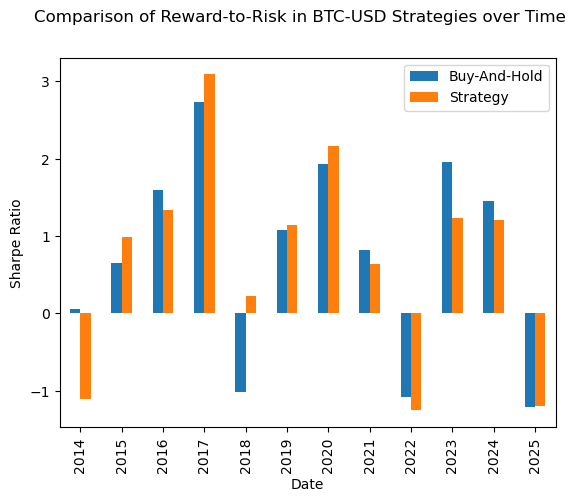

In [11]:
df = (
    btc_sma
    [['Return', 'Strategy']]
    .dropna()
    .rename(columns=COLUMNS)
    .resample('YE')
    .apply(lambda x: np.sqrt(252) * x.mean() / x.std())
)
df.index = df.index.year
df.plot(kind='bar')
plt.suptitle('Comparison of Reward-to-Risk in BTC-USD Strategies over Time')
plt.ylabel('Sharpe Ratio')
plt.show()

### Investigate how SMA(20) generates returns

Consider the following:

1. Does SMA(20) avoid the worst performing days? How many of the worst 20 days does SMA(20) avoid? Try the `.nlargest()` method.
1. Does SMA(20) preferentially avoid low-return days? Try to combine the `.groupby()` method and `pd.qcut()` function.
1. Does SMA(20) preferentially avoid high-volatility days? Try to combine the `.groupby()` method and `pd.qcut()` function.

The SMA(20) does well here because it avoids 17 of the 20 worst days, without avoiding the best days.

In [12]:
btc_sma.loc[btc_sma['Return'].nsmallest(20).index, ['Position']].value_counts()

Position
0.0000      17
1.0000       3
Name: count, dtype: int64

In [13]:
btc_sma.loc[btc_sma['Return'].nlargest(20).index, ['Position']].value_counts()

Position
0.0000      10
1.0000      10
Name: count, dtype: int64

We can also look at the descriptive statistics by `Postiion` and strategy.
Two observations:

1. The `min` column shows that SMA(20) misses the bad days, like we see above
2. The `mean` in `Position=1` is about 5 times higher than in `Position=0`

In [14]:
(
    btc_sma
    [['Position', 'Return', 'Strategy']]
    .dropna()
    .groupby('Position')
    .describe()
    .rename(columns=COLUMNS)
    .rename_axis(columns=['Strategy', 'Statistic'])
    .stack('Strategy', future_stack=True)
)

Statistic                 count   mean    std     min     25%    50%    75%  \
Position Strategy                                                             
0.0000   Buy-And-Hold 1717.0000 0.0007 0.0390 -0.3717 -0.0138 0.0012 0.0162   
         Strategy     1717.0000 0.0000 0.0000 -0.0000  0.0000 0.0000 0.0000   
1.0000   Buy-And-Hold 2091.0000 0.0032 0.0333 -0.1409 -0.0114 0.0013 0.0173   
         Strategy     2091.0000 0.0032 0.0333 -0.1409 -0.0114 0.0013 0.0173   

Statistic                 max  
Position Strategy              
0.0000   Buy-And-Hold  0.2394  
         Strategy     -0.0000  
1.0000   Buy-And-Hold  0.2525  
         Strategy      0.2525

We can also use the seaborn package to visualize `Position` (i.e., the portfolio weight on Bitcoin) during periods of high and low Bitcoin returns and volatility.
The SMA(20) strategy is long Bitcoin about 55% of the time, whether Bitcoin returns are high (bin 2) or low (bin 1).

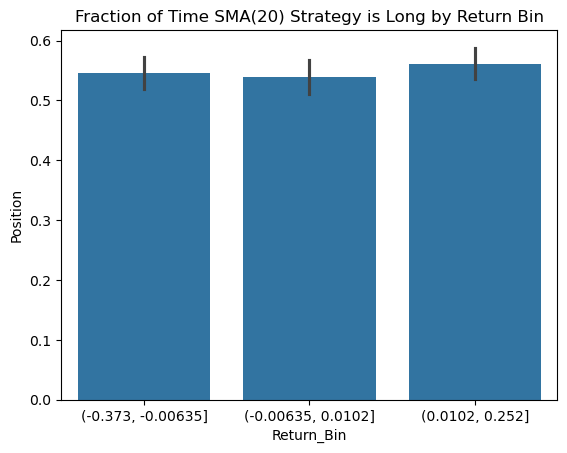

In [15]:
(
    btc_sma
    [['Return', 'Position']]
    .dropna()
    .assign(Return_Bin=lambda x: pd.qcut(x['Return'], q=3))
    .pipe(
        sns.barplot,
        x='Return_Bin',
        y='Position'
    )
)

plt.title('Fraction of Time SMA(20) Strategy is Long by Return Bin')
plt.show()

However, the SMA(20) stateegy, *for this security, sample, and window,* spends less times in Bitcoind during volatilit times.

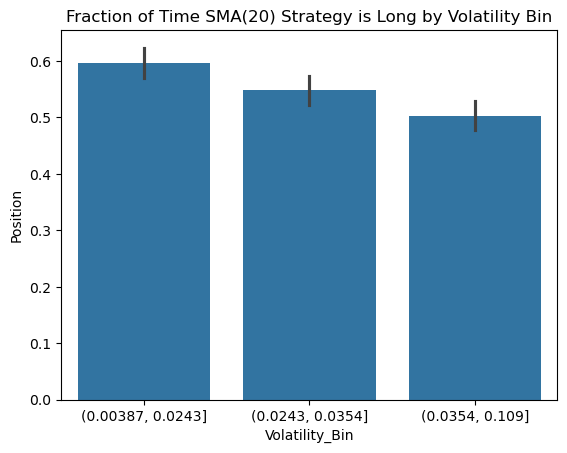

In [16]:
(
    btc_sma
    [['Return', 'Position']]
    .dropna()
    .assign(Volatility_Bin=lambda x: pd.qcut(x['Return'].rolling(20).std(), q=3))
    .pipe(
        sns.barplot,
        x='Volatility_Bin',
        y='Position'
    )
)

plt.title('Fraction of Time SMA(20) Strategy is Long by Volatility Bin')
plt.show()

### Implement the SMA(20) strategy with IBM

How often does SMA(20) outperform buy-and-hold with 10-year rolling windows?

In [17]:
ibm = (
    yf.download(
        tickers='IBM',
        auto_adjust=False,
        progress=False,
        multi_level_index=False
    )
    .iloc[:-1] # drop incomplete trading day
)


In [18]:
ibm_sma = ibm.pipe(calc_sma, window=20)

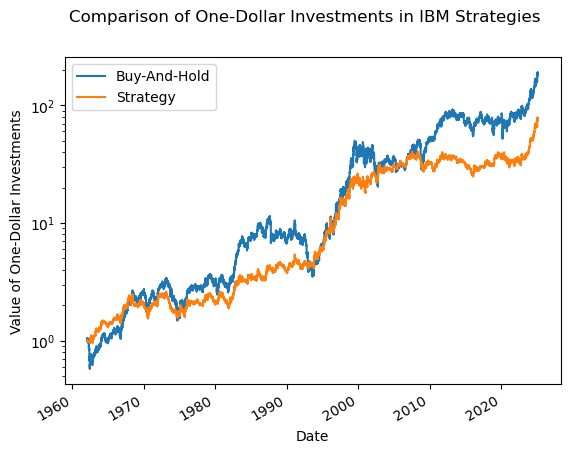

In [19]:
(
    ibm_sma
    [['Return', 'Strategy']]
    .dropna()
    .rename(columns=COLUMNS)
    .add(1)
    .cumprod()
    .plot()
)
plt.semilogy()
plt.suptitle('Comparison of One-Dollar Investments in IBM Strategies')
plt.ylabel('Value of One-Dollar Investments')
plt.show()

Over the full, 60-year sample, SMA(20) underperforms buy-and-hold.
What about on rolling ten-year windows?
The results look balanced, and neither clearly outperforms.

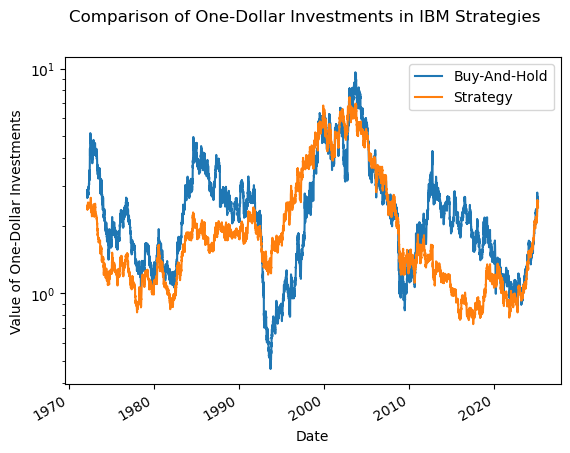

In [20]:
(
    ibm_sma
    [['Return', 'Strategy']]
    .dropna()
    .rename(columns=COLUMNS)
    .rolling(window=10*252)
    .apply(lambda x: (1 + x).prod())
    .plot()
)
plt.semilogy()
plt.suptitle('Comparison of One-Dollar Investments in IBM Strategies')
plt.ylabel('Value of One-Dollar Investments')
plt.show()

We can quantify how often SMA(20) outperform buy-and-hold.
SMA(20) outperforms only 24% of the time!

In [21]:
(
    ibm_sma
    [['Return', 'Strategy']]
    .dropna()
    .rolling(window=10*252)
    .apply(lambda x: (1 + x).prod())
    .pipe(lambda x: x['Strategy'] > x['Return'])
    .mean()
)

0.2315

### Implement a long-only BB(20, 2) strategy with Bitcoin

Bollinger Bands are bands around a trend, typically defined in terms of simple moving averages and volatilities.
A long-only BB(20, 2) strategy has upper and lower bands at 2 standard deviations above and below the SMA(20).
It invests as follows:

1. Buy when the closing price crosses LB(20) from below
1. Sell when the closing price crosses UB(20) from above
1. No short-selling

The long-only BB(20, 2) is more difficult to implement than the long-only SMA(20) because we need to track buys and sells.
For example, if the closing price is between LB(20) and BB(20), we need to know if our last trade was a buy or a sell.
Further, if the closing price is below LB(20), we can still be long because we sell when the closing price crosses UB(20) from above.

More on Bollinger Bands [here](https://www.bollingerbands.com/bollinger-bands) and [here](https://www.bollingerbands.com/bollinger-band-rules).

### Implement a long-short RSI(14) strategy with Bitcoin

From [Fidelity](https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/rsi):

> The Relative Strength Index (RSI), developed by J. Welles Wilder, is a momentum oscillator that measures the speed and change of price movements. The RSI oscillates between zero and 100. Traditionally the RSI is considered overbought when above 70 and oversold when below 30. Signals can be generated by looking for divergences and failure swings. RSI can also be used to identify the general trend.

The RSI formula: $RSI(n) = 100 - \frac{100}{1 + RS(n)}$, where $RS(n) = \frac{SMA(U, n)}{SMA(D, n)}$.
For "up days", $U = \Delta \text{Adj\ Close}$ and $D = 0$.
For "down days", $U = 0$ and $D = - \Delta \text{Adj\ Close}$.

We will implement a long-short RSI(14) as follows:

1. Buy when the RSI crosses 30 from below, and sell when the RSI crosses 50 from below
1. Short when the RSI crosses 70 from above, and cover when the RSI crosses 50 from above

More about RSI [here](https://en.wikipedia.org/wiki/Relative_strength_index).